This is the notebook to show the implementation of score-based generative model with SDE (2nd part of the tutorial). In this case, we will sample the training data from the swiss roll distribution like the previous part.
From the training data, we will try to learn how to draw new samples from the swiss roll distribution with Score-based Generative Model (SGM)

In [1]:
import torch
import torchvision

# generate the MNIST dataset
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
mnist_dset = torchvision.datasets.MNIST("mnist", download=True, transform=transforms)
print(mnist_dset[0][0].shape)

torch.Size([1, 28, 28])


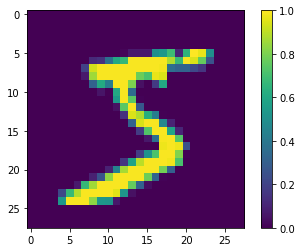

In [2]:
# show a sample
import matplotlib.pyplot as plt
# the first index is for the dataset, the second is for the tuple, the third one is for channel
plt.imshow(mnist_dset[0][0][0])
plt.colorbar()

The neural network to learn the score function is a U-Net architecture that accepts the image + the time and produce the score function with the same shape as the image.

In [3]:
class ScoreNetwork0(torch.nn.Module):
    # takes an input image and time, returns the score function
    def __init__(self):
        super().__init__()
        nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(2, chs[0], kernel_size=3, padding=1),  # (batch, ch, 28, 28)
                torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, ch, 14, 14)
                torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, ch, 7, 7)
                torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (batch, ch, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, ch, 4, 4)
                torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, ch, 2, 2)
                torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
            ),
        ])
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (batch, 32, 7, 7)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[2], 14, 14)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[1], 28, 28)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, chs[0], 28, 28)
                torch.nn.LogSigmoid(),
                torch.nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),  # (batch, 1, 28, 28)
            ),
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        x2 = torch.reshape(x, (*x.shape[:-1], 1, 28, 28))  # (..., ch0, 28, 28)
        tt = t[..., None, None].expand(*t.shape[:-1], 1, 28, 28)  # (..., 1, 28, 28)
        x2t = torch.cat((x2, tt), dim=-3)
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        return signal

score_network = ScoreNetwork0()

Now let's implement the denoising score matching function below (same as before),
$$\begin{equation}
\mathcal{L}(\theta) = \int_0^1\lambda (t) \mathbb{E}_{\mathbf{x}(0)}\mathbb{E}_{\mathbf{x}(t)|\mathbf{x}(0)}\left[\left\lVert\mathbf{s}(\mathbf{x}(t), t; \theta) - \nabla_{\mathbf{x}(0)}\mathrm{log}\ p(\mathbf{x}(t)|\mathbf{x}(0))\right\rVert^2\right]\ dt
\end{equation}$$
where $\lambda(t) = 1 - \mathrm{exp}\left[-\int_0^t \beta(s) ds\right]$ and $\nabla_{\mathbf{x}(0)}\mathrm{log}\ p(\mathbf{x}(t)|\mathbf{x}(0))$ can be calculated analytically,
$$\begin{align}
\nabla_{\mathbf{x}(0)}\mathrm{log}\ p(\mathbf{x}(t)|\mathbf{x}(0)) &= -\frac{\mathbf{x}(t) - \boldsymbol{\mu}(t)}{\sigma^2(t)} \\
\boldsymbol{\mu}(t) &= \mathbf{x}(0)\mathrm{exp}\left[-\frac{1}{2}\int_0^t \beta(s) ds\right] \\
\sigma^2(t) &= 1 - \mathrm{exp}\left[-\int_0^t \beta(s) ds\right]
\end{align}$$
with $\beta(t) = 0.1 + (20 - 0.1) t$.

In [4]:
def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, nch) is the training data
    
    # sample the time
    t = torch.rand((x.shape[0], 1), dtype=x.dtype, device=x.device) * (1 - 1e-4) + 1e-4

    # calculate the terms for the posterior log distribution
    int_beta = (0.1 + 0.5 * (20 - 0.1) * t) * t  # integral of beta
    mu_t = x * torch.exp(-0.5 * int_beta)
    var_t = -torch.expm1(-int_beta)
    x_t = torch.randn_like(x) * var_t ** 0.5 + mu_t
    grad_log_p = -(x_t - mu_t) / var_t  # (batch_size, nch)

    # calculate the score function
    score = score_network(x_t, t)  # score: (batch_size, nch)

    # calculate the loss function
    loss = (score - grad_log_p) ** 2
    lmbda_t = var_t
    weighted_loss = lmbda_t * loss
    return torch.mean(weighted_loss)


Everything is ready, now we can start the training. We use batch size 64 with about 400 epochs. Please be aware that the training could take about 2 hours with a GPU (NVIDIA T4).

In [5]:
# start the training loop
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(mnist_dset, batch_size=64, shuffle=True)
device = torch.device('cuda:0')  # change this if you don't have a gpu
score_network = score_network.to(device)
t0 = time.time()
for i_epoch in range(400):
    total_loss = 0
    for data, _ in dloader:  # we don't need the data class
        data = data.reshape(data.shape[0], -1).to(device)
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 20 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(mnist_dset)}")


0 (17.730889558792114s): 0.22341656593084336
20 (401.8917303085327s): 0.029081364569067954
40 (790.7225224971771s): 0.023310251233975093
60 (1189.1614212989807s): 0.02070757134358088
80 (1576.9579727649689s): 0.019138541827599206
100 (1968.4040081501007s): 0.018990544128914676
120 (2350.477967977524s): 0.017998353243867556
140 (2714.2453112602234s): 0.017528612997631234
160 (3078.988071203232s): 0.016947320915261903
180 (3441.6967012882233s): 0.016829439407090346
200 (3803.7253336906433s): 0.016393583998580773
220 (4166.092226266861s): 0.016545733177661896
240 (4529.129833221436s): 0.01611548722734054
260 (4892.061001300812s): 0.01601907907028993
280 (5254.657285451889s): 0.015872681791583697
300 (5616.805672168732s): 0.016094734780987104
320 (5978.815507650375s): 0.015912713130315146
340 (6340.980444908142s): 0.015442739987870057
360 (6705.336601495743s): 0.015590764922400316
380 (7069.732095956802s): 0.015302305275698503


Once the neural network is trained, we can generate the samples using reverse SDE

$$\begin{equation}
\mathrm{d}\mathbf{x} = \left[\mathbf{f}(\mathbf{x}, t) - g(t)^2\mathbf{s}(\mathbf{x}, t; \theta)\right]\ \mathrm{d}t + g(t)\ \mathrm{d}\mathbf{w},
\end{equation}$$

where $\mathbf{f}(\mathbf{x}, t) = -\frac{1}{2}\beta(t)\mathbf{x}$, $g(t) = \sqrt{\beta(t)}$, and the integration time goes from 1 to 0.
To solve the SDE, we can use the Euler-Maruyama method.

In [6]:
def generate_samples(score_network: torch.nn.Module, nsamples: int) -> torch.Tensor:
    device = next(score_network.parameters()).device
    x_t = torch.randn((nsamples, 28 * 28), device=device)  # (nsamples, nch)
    time_pts = torch.linspace(1, 0, 1000, device=device)  # (ntime_pts,)
    beta = lambda t: 0.1 + (20 - 0.1) * t
    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        fxt = -0.5 * beta(t) * x_t
        gt = beta(t) ** 0.5
        score = score_network(x_t, t.expand(x_t.shape[0], 1)).detach()
        drift = fxt - gt * gt * score
        diffusion = gt

        # euler-maruyama step
        x_t = x_t + drift * dt + diffusion * torch.randn_like(x_t) * torch.abs(dt) ** 0.5
    return x_t

In [7]:
samples = generate_samples(score_network, 20).detach().reshape(-1, 28, 28)

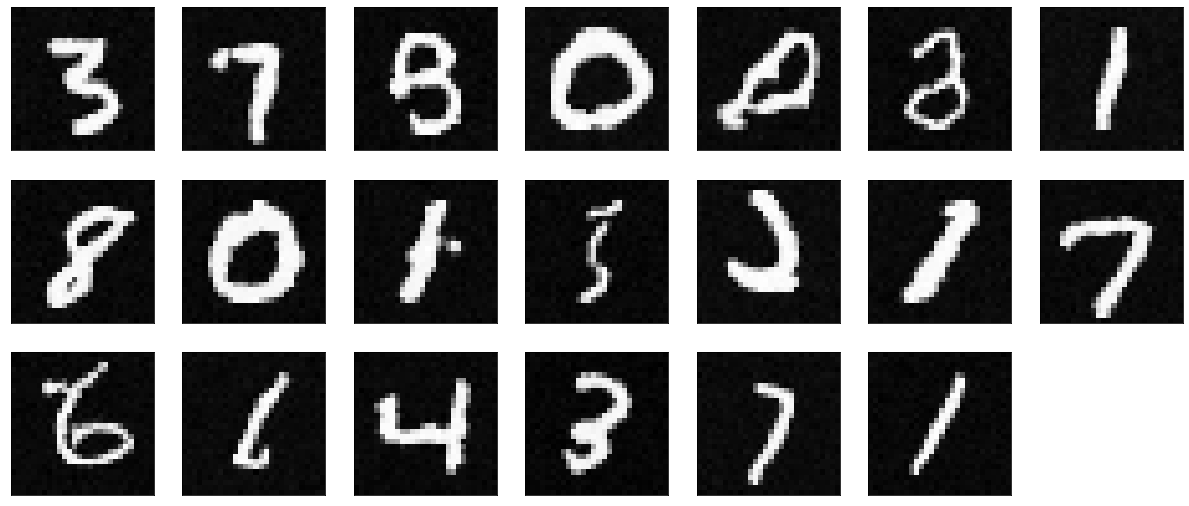

In [11]:
nrows, ncols = 3, 7
plt.figure(figsize=(3 * ncols, 3 * nrows))
for i in range(samples.shape[0]):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(1 - samples[i].detach().cpu().numpy(), cmap="Greys")
    plt.xticks([])
    plt.yticks([])